# Loading dataset and performing EDA + modeling for heart disease prediction
# This code will:
# 1. Load ../Healthcare/dataset/heart.csv
# 2. Show head, shape, data types, missing values, summary stats
# 3. Show target distribution and chest pain counts (if present)
# 4. Compute correlations and show a correlation matrix plot
# 5. Preprocess features (one-hot encode categorical columns where appropriate)
# 6. Train/test split, scale numeric features
# 7. Train Logistic Regression and Random Forest classifiers
# 8. Evaluate models (accuracy, ROC-AUC, classification report, confusion matrix)
# 9. Show feature importances for Random Forest and coefficient magnitudes for Logistic Regression
# 10. Plot ROC curve for the best model

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = Path(r"..\Healthcare\dataset\heart.csv")
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path}")

In [3]:
# 1. Load dataset
df = pd.read_csv(data_path)
print("Dataset loaded from:", data_path)
print("\nShape:", df.shape)

Dataset loaded from: ..\Healthcare\dataset\heart.csv

Shape: (1025, 14)


In [4]:
# 2. Quick look
display(df.head())
print("\nData types:")
print(df.dtypes)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


In [5]:

# 3. Missing values and basic stats
print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics (numeric columns):")
display(df.describe().T)

# Identify target column (common names: target, disease, heart_disease)
possible_targets = [c for c in df.columns if c.lower() in ("target", "disease", "heartdisease", "heart_disease", "has_disease", "condition")]
print("\nPossible target columns found:", possible_targets)

# If none, we'll ask and try to infer common column names; otherwise assume 'target' if present.
target_col = None
if "target" in df.columns:
    target_col = "target"
elif possible_targets:
    target_col = possible_targets[0]
else:
    # try common alternate names
    for name in ["heart_disease", "disease", "HeartDisease", "num"]:
        if name in df.columns:
            target_col = name
            break
if target_col is None:
    # fallback to last column
    target_col = df.columns[-1]
print("Using target column:", target_col)


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Summary statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2



Possible target columns found: ['target']
Using target column: target


In [ ]:
# 4. Target distribution
print("\nTarget value counts:")
print(df[target_col].value_counts(dropna=False))



Target value counts:
target
1    526
0    499
Name: count, dtype: int64


In [7]:
# 5. Inspect categorical columns commonly used in heart datasets
print("\nUnique values for some likely categorical columns (if present):")
for col in ["cp", "sex", "fbs", "exang", "slope", "ca", "thal"]:
    if col in df.columns:
        print(f"{col}: {sorted(df[col].unique())}")


Unique values for some likely categorical columns (if present):
cp: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
sex: [np.int64(0), np.int64(1)]
fbs: [np.int64(0), np.int64(1)]
exang: [np.int64(0), np.int64(1)]
slope: [np.int64(0), np.int64(1), np.int64(2)]
ca: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
thal: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


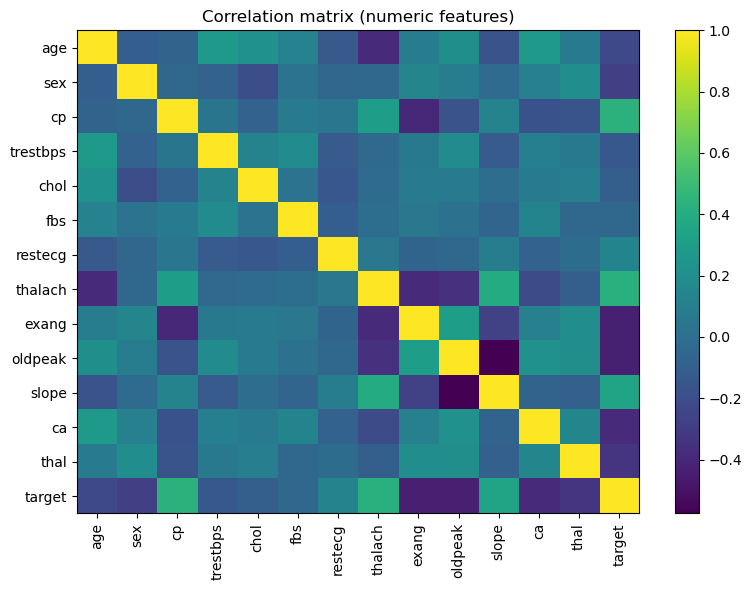

In [8]:
# 6. Correlation matrix for numeric columns
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(8,6))
plt.title("Correlation matrix (numeric features)")
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

In [9]:
# 7. Preprocessing: select features for modeling based on problem statement but allow others
# We'll use: age, chol (cholesterol), trestbps (resting blood pressure), thalach (max heart rate achieved), cp (chest pain)
# If any are missing from dataset, use available numeric columns.
desired_features = ["age", "chol", "trestbps", "thalach", "cp"]
available = [f for f in desired_features if f in df.columns]
print("\nDesired features available:", available)

# If cp present and categorical, we will one-hot encode it.
features = available.copy()
X = df[features].copy()
y = df[target_col].copy()

# If cp exists but is numeric categories, convert to string then get_dummies
if "cp" in X.columns:
    X["cp"] = X["cp"].astype(str)

# One-hot encode categorical columns in X (only cp here)
X = pd.get_dummies(X, drop_first=True)

# For any remaining non-numeric columns, drop them
X = X.select_dtypes(include=[np.number])

print("\nFinal feature columns used for modeling:")
print(list(X.columns))


Desired features available: ['age', 'chol', 'trestbps', 'thalach', 'cp']

Final feature columns used for modeling:
['age', 'chol', 'trestbps', 'thalach']


In [10]:
# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (820, 4) Test shape: (205, 4)


In [11]:
# 9. Scaling numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# 10. Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

In [13]:
# 11. Train Random Forest (with a small grid search for reasonable params)
rf = RandomForestClassifier(random_state=42)
param_grid = {"n_estimators":[100], "max_depth":[4,6,8]}
gs = GridSearchCV(rf, param_grid, cv=4, scoring="roc_auc", n_jobs=-1)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

In [14]:
# 12. Evaluation
def evaluate_model(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    print(f"\n{name} - Accuracy: {acc:.4f}  ROC-AUC: {roc:.4f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("Random Forest (best)", y_test, y_pred_rf, y_proba_rf)


Logistic Regression - Accuracy: 0.7073  ROC-AUC: 0.7416
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       100
           1       0.69      0.77      0.73       105

    accuracy                           0.71       205
   macro avg       0.71      0.71      0.71       205
weighted avg       0.71      0.71      0.71       205

Confusion matrix:
[[64 36]
 [24 81]]

Random Forest (best) - Accuracy: 0.9415  ROC-AUC: 0.9785
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.94      0.94      0.94       105

    accuracy                           0.94       205
   macro avg       0.94      0.94      0.94       205
weighted avg       0.94      0.94      0.94       205

Confusion matrix:
[[94  6]
 [ 6 99]]


In [15]:
# 13. Feature importance
print("\nRandom Forest feature importances:")
rf_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(rf_imp)

print("\nLogistic Regression coefficients (absolute value, sorted):")
lr_coef = pd.Series(np.abs(lr.coef_[0]), index=X.columns).sort_values(ascending=False)
display(lr_coef)


Random Forest feature importances:


thalach     0.352054
age         0.266340
chol        0.209754
trestbps    0.171851
dtype: float64


Logistic Regression coefficients (absolute value, sorted):


thalach     1.001231
trestbps    0.304342
chol        0.164806
age         0.119469
dtype: float64

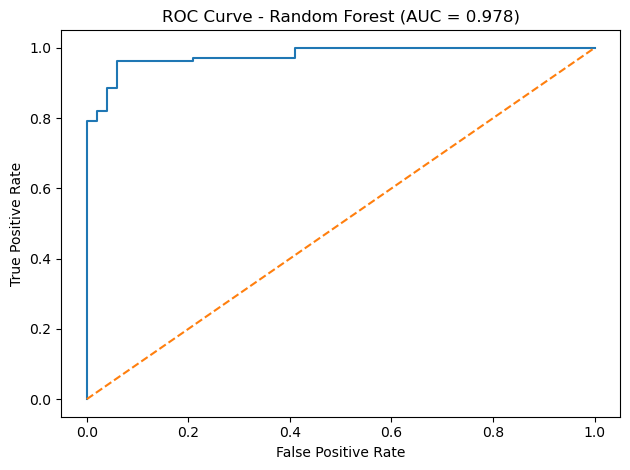

In [16]:
# 14. ROC curve for best of the two by ROC-AUC
roc_lr = roc_auc_score(y_test, y_proba_lr)
roc_rf = roc_auc_score(y_test, y_proba_rf)
best_name = "Random Forest" if roc_rf >= roc_lr else "Logistic Regression"
best_proba = y_proba_rf if best_name=="Random Forest" else y_proba_lr

fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_name} (AUC = {roc_auc:.3f})")
plt.tight_layout()
plt.show()

In [17]:

# 15. Save the final model and scaler for download
import joblib
out_dir = Path(r"..\Healthcare\modeloutput")
out_dir.mkdir(exist_ok=True)
joblib.dump(best_rf, out_dir/"best_rf.joblib")
joblib.dump(scaler, out_dir/"scaler.joblib")
joblib.dump(lr, out_dir/"logistic_regression.joblib")
print("\nSaved models to:", out_dir)

# Display a compact EDA summary table
eda_summary = pd.DataFrame({
    "feature": X.columns,
    "mean": X.mean().values,
    "std": X.std().values,
    "rf_importance": best_rf.feature_importances_,
    "lr_coef_abs": np.abs(lr.coef_[0])
}).sort_values("rf_importance", ascending=False)

# Display the summary table
from IPython.display import display
display("EDA + Feature Summary", eda_summary.reset_index(drop=True))

print("\nFiles created for download:")
for p in out_dir.iterdir():
    print(p)





Saved models to: ..\Healthcare\modeloutput


'EDA + Feature Summary'

,feature,mean,std,rf_importance,lr_coef_abs
0,thalach,149.114146,23.005724,0.352054,1.001231
1,age,54.434146,9.072290,0.266340,0.119469
2,chol,246.000000,51.592510,0.209754,0.164806
3,trestbps,131.611707,17.516718,0.171851,0.304342



Files created for download:
..\Healthcare\modeloutput\best_rf.joblib
..\Healthcare\modeloutput\logistic_regression.joblib
..\Healthcare\modeloutput\scaler.joblib
